In [3]:
import numpy as np
import torch
import pandas as pd
import os
from PIL import Image
from torchvision import transforms

In [4]:
dataset_dir = "./mnist/"
metadata_file = "mnist.csv"
metadata_path = os.path.join(dataset_dir, metadata_file)

metadata = pd.read_csv(metadata_path)

In [5]:
metadata["filename"][0]

'00000.png'

In [6]:
# create a tensor with all the images
images = []
transform = transforms.ToTensor()

for path in metadata["filename"]:
    img = Image.open(os.path.join(dataset_dir, path))
    tensor_image = transform(img)
    images.append(tensor_image)

all_images = torch.stack(images)

In [7]:
all_images.size()

torch.Size([70000, 1, 28, 28])

In [8]:
# normalize the all_images tensor to have zero mean and 1 std dev
all_images = all_images.float()
mean = all_images.mean()
std = all_images.std()
all_images = (all_images - mean) / std

In [9]:
print(f"mean: {mean}, std: {std}")

mean: 0.13092535734176636, std: 0.30844852328300476


In [10]:
import torch.nn.functional as F

In [11]:
# upsample the images to 32x32
upsampled_images = F.interpolate(all_images, size=32)

In [12]:
upsampled_images.size()

torch.Size([70000, 1, 32, 32])

In [13]:
import matplotlib.pyplot as plt

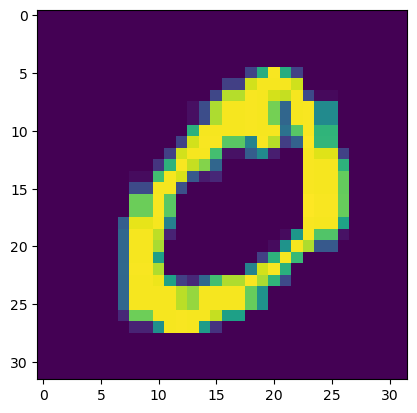

In [14]:
plt.imshow(upsampled_images[1].permute(1, 2, 0))

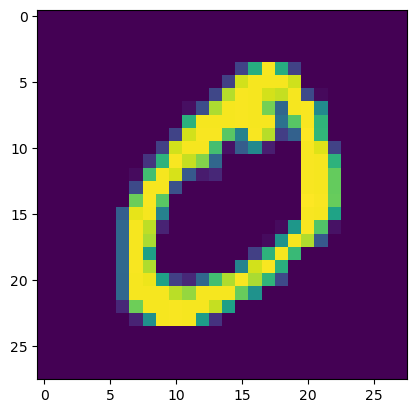

In [15]:
plt.imshow(all_images[1].permute(1, 2, 0))

In [2]:
from src.model import Unet

In [16]:
!nvidia-smi

Sat Dec 30 13:13:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   22C    P8     8W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [24]:
from typing import Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import numpy as np
import numpy.typing as npt


T: int = 1000
beta_1: float = 1e-4
beta_T: float = 0.02
# following 3 for mnist
in_c: int = 1
in_h: int = 32
in_w: int = 32

lr: float = 6 * 1e-4
n_epoch: int = 2
batch_size: int = 32

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")


def get_beta_t(t: int) -> float:
    assert 1 <= t and t <= T, f"time index {t} must be in range [1, {T}]"
    return (beta_1 * (T - t) + beta_T * (t - 1)) / (T - 1)


betas: npt.NDArray[np.float_] = np.array([get_beta_t(t) for t in range(1, T + 1)])
alphas: torch.Tensor = torch.from_numpy(np.cumprod(1 - betas))
alphas = alphas.to(device=device)


class DiffusionTrainingDataset(Dataset):
    def __init__(self, data: torch.Tensor):
        # assume that the input data has already been preprocessed into shape (N, in_c, in_h, in_w)
        assert data.ndim == 4 and data.shape[1:] == (in_c, in_h, in_w)
        # using mnist right now, can just load the whole dataset to cuda
        self.data = data.to(device=device)

    def __len__(self):
        return len(self.data)

    def __getitem__(
        self, idx: int
    ) -> Tuple[npt.NDArray[np.float_], npt.NDArray[np.float_], int]:
        """
        return the i-th data, along with a random normal of same shape, and a random time step in {1, ..., T}
        """
        return (
            self.data[idx, ...],
            torch.randn((in_c, in_h, in_w), device=device),
            torch.randint(1, T + 1, (1,)),
        )


# TODO substitute with some actual data
train_dataloader = DataLoader(
    DiffusionTrainingDataset(upsampled_images),
    batch_size=batch_size,
    shuffle=True,
)

model = Unet(
    c_start=in_c,
)
model.to(device=device)

loss_fn = F.mse_loss
optimizer = optim.Adam(model.parameters(), lr=lr)

model.train()
for i in range(n_epoch):
    for j, batch in enumerate(train_dataloader):
        print(f"training batch {j}")
        data, noise, times = batch
        #data, noise, times = (
        #    torch.from_numpy(data),
        #    torch.from_numpy(noise),
        #    torch.from_numpy(times),
        #)
        #data, noise, times = data.to(device), noise.to(device), times.to(device)
        optimizer.zero_grad()
        alpha_ts = alphas[times].reshape(-1, 1, 1, 1)
        x_ts = torch.sqrt(alpha_ts) * data + torch.sqrt(1 - alpha_ts) * noise
        print(f"x_ts on device {x_ts.device}, data on device {data.device}, noise on device {noise.device}, times on device {times.device}")
        pred = model(x_ts, times)
        loss_vals = loss_fn(pred, noise)
        optimizer.step()
    print(f"finished epoch {i}")

# TODO save the model when we actually have a real model
# torch.save(model.state_dict(), "model.pth")

training batch 0


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)